In [1]:
import pandas as pd
data = pd.read_csv('/content/london_weather.csv',sep=',')

In [2]:
data.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [3]:
data.shape

(15341, 10)

In [4]:
data.reset_index(drop=True, inplace=True)
data['step'] = data.index

In [5]:
data

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,step
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,2
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,3
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN,15336
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN,15337
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN,15338
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN,15339


In [6]:
data = data[['date', 'max_temp', 'step']]

In [7]:
data

,date,max_temp,step
0,19790101,2.3,0
1,19790102,1.6,1
2,19790103,1.3,2
3,19790104,-0.3,3
4,19790105,5.6,4
...,...,...,...
15336,20201227,7.5,15336
15337,20201228,3.6,15337
15338,20201229,4.1,15338
15339,20201230,5.6,15339


In [8]:
data = data.dropna()

In [9]:
data.shape

(15335, 3)

##PLOT Series

In [10]:
import matplotlib.pyplot as plt

In [11]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):

    plt.figure(figsize=(14, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [12]:
max_temp_time_step = list(data['step'])
max_temp_list = list(data['max_temp'])

In [13]:
import numpy as np
max_temp_time = np.array(max_temp_time_step)
max_temp_series = np.array(max_temp_list)

In [14]:
max_temp_series

array([2.3, 1.6, 1.3, ..., 4.1, 5.6, 1.5])

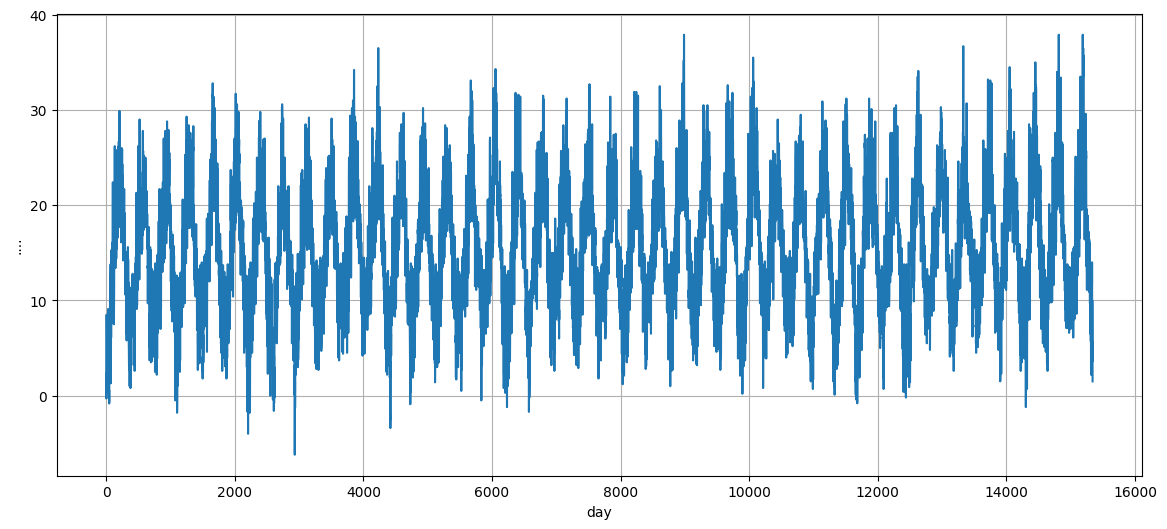

In [15]:
plot_series(max_temp_time, max_temp_series, xlabel='day', ylabel='....')

##SPLIT DATASET

In [16]:
split_time = 12268 # 20%
time_train = max_temp_time[:split_time]
x_train = max_temp_series[:split_time]
time_valid = max_temp_time[split_time:]
x_valid = max_temp_series[split_time:]

In [17]:
time_train.shape

(12268,)

In [18]:
import tensorflow as tf

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [20]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [21]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

##MODELING

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
    # tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │             990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,983 (54.62 KB)

 Trainable params: 13,983 (54.62 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
init_weights = model.get_weights()
model.set_weights(init_weights)

In [24]:
threshold = (data['max_temp'].max() - data['max_temp'].min()) * 10/100
print(threshold)

4.41


In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<4.41):
            print("\n MAE is less than 10% of data scale")
            self.model.stop_training = True


callbacks = myCallback()

In [26]:
learning_rate = 7e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [27]:
history = model.fit(train_set,epochs=50)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 13.5037 - mae: 14.0025
Epoch 2/50
  9/383 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 12.3056 - mae: 12.8054   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 12.2537 - mae: 12.7519
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 10.5705 - mae: 11.0670
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.1874 - mae: 8.6784
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.4680 - mae: 5.9484
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8411 - mae: 4.3146
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.7769 - mae: 3.2407
Epoch 8/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.2513 - mae: 2.7086
Epoch 9/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.0056 - mae: 2.4594
Epoch 10/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.8950 - mae: 2.3476
Epoch 11/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.8273 - mae: 2.2797
Epoch 12/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.7667 - mae: 2.2186
Epoch 13/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.7318 - mae: 2.1846
Epoch 14/50
383/383 ━━━━━━━━━

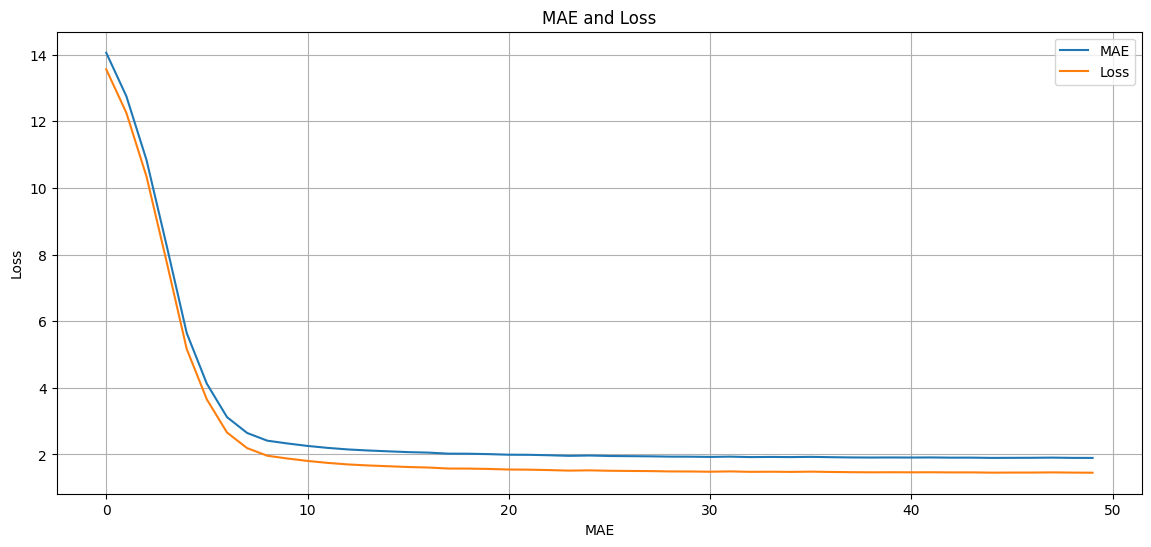

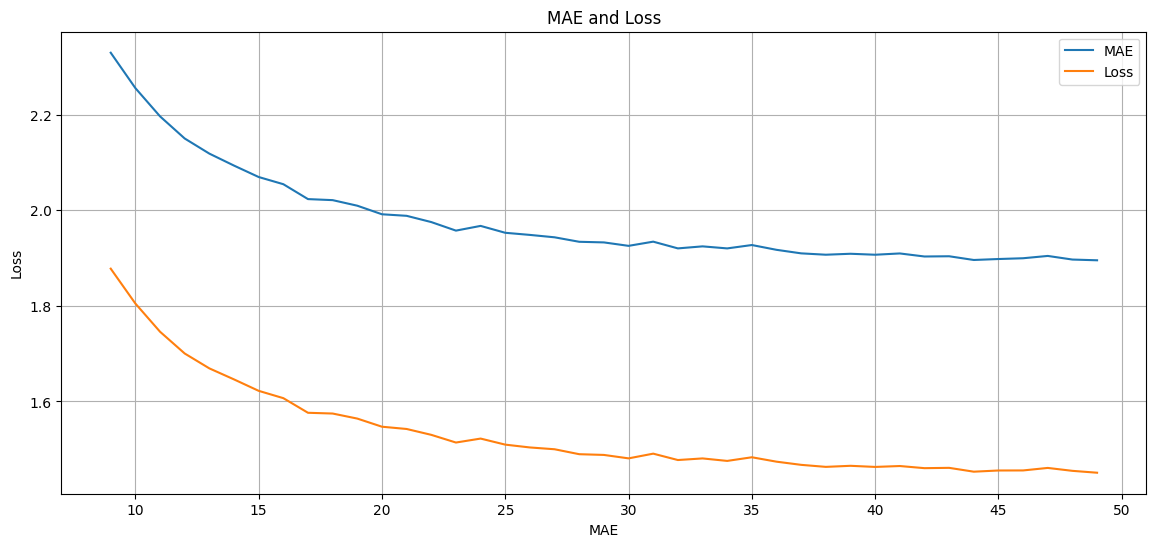

In [28]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [29]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


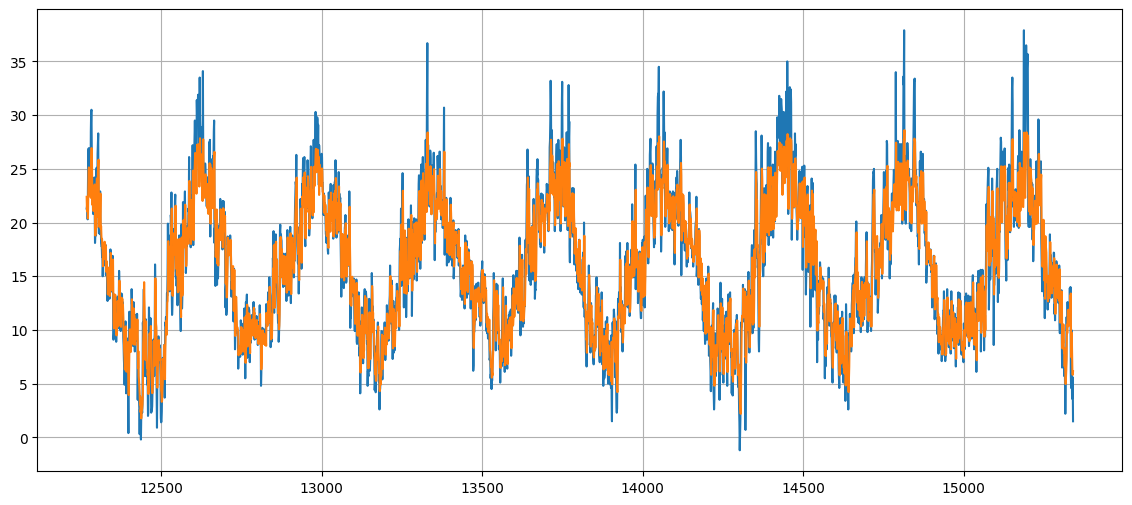

In [30]:
forecast_series = max_temp_series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))